In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from collections import namedtuple, OrderedDict
import attr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from pf.pfasst import PFASST, Experiment, IMKParams, MagpicardParams
from tqdm import tqdm_notebook as tqdm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    
exe = '/home/bkrull/devel/pfasst-nwchem/block_worktree/test/imk/main.exe'
mag = '/home/bkrull/devel/pfasst-nwchem/libpfasst/tests/toda/main.exe'
exp = Experiment()

sns.set()
sns.set_style("whitegrid", {"legend.frameon": True})
sns.set_context("talk")
colors = sns.color_palette()

results_home = '/home/bkrull/Documents/script/script-imk/img/'

In [2]:
def plot_iteration_behavior(results, logy=True, fname=None):
    fig, ax = plt.subplots()
    for k, rr in results.iteritems():
        r = rr['val']
        ax.plot(r.dt.values,
        r.iterations.values, label=k, marker='o')

    ax.set_xscale("log", nonposx='clip')
    ax.set_xlabel('$\Delta t$')
    ax.set_ylabel('Mean Iterations per Step')

    if logy:
        ax.set_yscale("log", nonposy='clip')
        iters = np.linspace(0, 6, num=4)
        iters = np.power(2, iters).astype(np.float_)

    else:
        iters = np.linspace(0, 30, num=4)

    dt = np.linspace(-1, 0, num=2)
    dt = np.power(10, dt).astype(np.float_)

    ax.set_xticks(dt)
    ax.set_xticklabels(dt)
    ax.set_yticks(iters)
    ax.set_yticklabels(map(int, iters))
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if fname:
        fig.savefig(fname, dpi=300)

In [3]:
def plot_timings(results, fname=None):
    fig, ax = plt.subplots()

    for k, r in results.iteritems():
        if type(r) is list:
            continue

        times = []

        for time in r['val'].total_times:
            times.append(sum(time.values()))

        ax.plot(r['val'].nsteps.values, times, marker='o', label=k)

    ax.set_xlabel('Number of steps')
    ax.set_ylabel('Wall Time (seconds)')
    ax.legend()
    if fname:
        fig.savefig(fname, dpi=300)

In [4]:
def plot_convergence(results, fname=None):
    fig, ax = plt.subplots()
    for k, r in results.iteritems():
        ax.plot(r['val'].dt.values,
                r['val'].error.values,
                label=k, marker='o')

    ax.set_ylabel('Error')
    ax.set_xlabel('$\Delta t$')
    ax.set_xscale("log", nonposx='clip')
    ax.set_yscale("log", nonposy='clip')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if fname:
        fig.savefig(fname, dpi=150, bbox_inches="tight")

In [5]:
%pdb

Automatic pdb calling has been turned ON


env: OMP_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1
IMKParams(exe='/home/bkrull/devel/pfasst-nwchem/block_worktree/test/imk/main.exe', levels=1, tfinal=10.0, iterations=1, nsteps=128, nodes=[5], sweeps=[1], sweeps_pred=[0], tasks=1, nersc=False, dt=0.078125, timings=False, vcycle=True, tolerance=1e-12, qtype='lob', sdc=True, filename='imk.nml', inttype='imk', solutions=True, particles=11, periodic=True, nterms=[5], rk=False, mkrk=False, exptol=['1.d-15'], base_string='&pf_params\n\tnlevels = {}\n\tniters = {}\n\tqtype = {}\n\techo_timings = {}\n\tabs_res_tol = {}\n\trel_res_tol = {}\n\tpipeline_g = .true.\n\tpfasst_pred = .true.\n\tvcycle = {}\n/\n\n&params\n\tfbase = {}\n\tnnodes = {}\n\tnsweeps_pred = {}\n\tnsweeps = {}\n\tnterms = {}\n\ttfin = {}\n\tnsteps = {}\n\texptol = {}\n\tnparticles = {}\n\tsave_solutions = {}\n\ttoda_periodic = {}\n\tuse_sdc = {}\n\trk = {}\n\tmkrk = {}\n/\n', param_list=[1, 1, 1, '.false.', 1e-12, 1e-12, '.true.', '"output"', '5', '0', '1', '5', 10.0, 128, '

/home/bkrull/bin/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


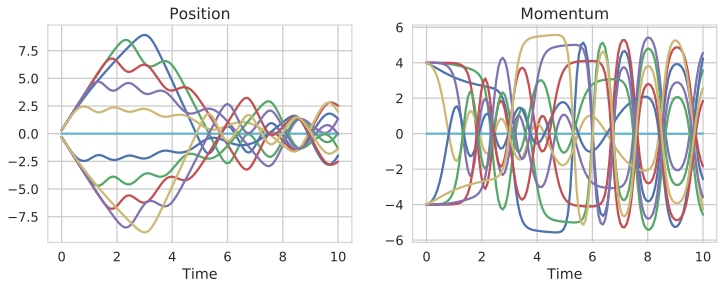

In [6]:
%rm output/*particles_11*
%set_env OMP_NUM_THREADS=1
%set_env OPENBLAS_NUM_THREADS=1
levels = 1
params_11 = IMKParams(inttype='imk', qtype='lob', levels=levels, exe=exe,
                   nterms=[5]*levels, nodes=[5]*levels, tfinal=10.0, 
                   sweeps=[1]*levels, sweeps_pred=[0]*levels, vcycle=True,
                   nsteps=128, solutions=True, iterations=1, sdc=True)
print(params_11)
toda_11 = PFASST(params_11)

results_rk = toda_11.run()[0]

fig, (ax1, ax2) = toda_11.plot_toda(results_rk, maxparticles=0)

In [10]:
results_4 = OrderedDict()
results_4['iMK-3(5)'] = {'levels': 1, 'nodes': [3], 'nterms': [5], 'sdc': True, 'inttype':'imk', 'val':[]}
results_4['iMK-5(7)'] = {'levels': 1, 'nodes': [5], 'nterms': [7], 'sdc': True, 'inttype':'imk', 'val':[]}

def evolve(**kwargs):
    levels = kwargs['levels']
    sweeps = sweeps_pred = [1]*levels
    inttype = kwargs['inttype']

    p = attr.evolve(toda.p, levels=levels, sweeps=sweeps, sweeps_pred=sweeps_pred, inttype=inttype, qtype='lob',
                    nodes=kwargs['nodes'], nterms=kwargs['nterms'], sdc=kwargs['sdc'])
        
    return p

slope = 4.02888885109


slope = 5.16606711031



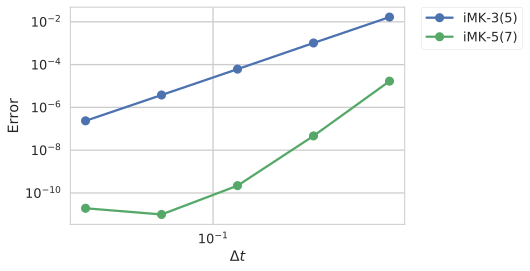

In [11]:
%rm output/*

params = IMKParams(inttype='imk', qtype='lobatto', particles=11,
                sdc=True, vcycle=True, tfinal=1.0, iterations=50)

nsteps = range(1, 6)
for k, r in tqdm(results_4.iteritems(), total=len(results_4), desc='method progress'):
    params.exe = exe
        
    toda = PFASST(params)
    toda.p = evolve(**r)

    r['val'] = exp.convergence_exp(toda, steps=nsteps)
    
plot_convergence(results_4)